# Tables and Figures
Author: Mark Bauer

In [1]:
# import packages
import duckdb
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from datetime import date
import cpi

plt.rcParams['savefig.facecolor'] = 'white'

In [2]:
# reproducibility
%reload_ext watermark
%watermark -v -p duckdb,numpy,pandas,seaborn,geopandas,matplotlib,cpi

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.6.0

duckdb    : 1.0.0
numpy     : 1.23.4
pandas    : 1.5.1
seaborn   : 0.12.1
geopandas : 0.12.1
matplotlib: 3.6.2
cpi       : 2.0.6



# Introduction
This notebook's purpose is to generate tables and figures for the repository's [README](https://github.com/mebauer/duckdb-fema-nfip/blob/main/README.md) file. Inspiration was taken from FEMA's [Historical NFIP Claims Information and Trends](https://www.floodsmart.gov/historical-nfip-claims-information-and-trends?map=countries/us/custom/us-all-territories&region=us&miny=all&maxy=all&county=&gtype=country) data visualizations. For a more thorough analysis of the NFIP, please see the [analysis](https://github.com/mebauer/duckdb-fema-nfip/blob/main/analysis.ipynb) notebook.

In [3]:
# sanity check, list datasets
%ls data/

FimaNfipClaims.parquet


In [4]:
# preview size of file
!du -sh data/* | sort -rh

194M	data/FimaNfipClaims.parquet


# Create a DuckDB Database Instance

In [5]:
# create a DuckDB database instance
con = duckdb.connect()

# create table claims of dataset
con.execute("""
    CREATE TABLE claims AS
        FROM read_parquet('data/FimaNfipClaims.parquet')
""")

# quick preview, sanity check
con.sql("""
    SELECT *
    FROM claims
    LIMIT 5
""").show()

┌──────────────────────┬──────────────────────┬───┬──────────────┬──────────────┬──────────────────────┐
│ agricultureStructu…  │       asOfDate       │ … │   latitude   │  longitude   │          id          │
│       boolean        │ timestamp with tim…  │   │ decimal(9,1) │ decimal(9,1) │         uuid         │
├──────────────────────┼──────────────────────┼───┼──────────────┼──────────────┼──────────────────────┤
│ false                │ NULL                 │ … │         39.2 │        -74.6 │ a4edd1e3-a2cc-4ea7…  │
│ false                │ NULL                 │ … │         29.9 │        -95.3 │ 5fa56e50-7923-44f3…  │
│ false                │ NULL                 │ … │         40.0 │        -74.1 │ ee43a296-bc2b-4b49…  │
│ false                │ NULL                 │ … │         29.9 │        -95.4 │ 2d96f6b6-d33b-4eda…  │
│ false                │ NULL                 │ … │         26.4 │        -81.9 │ 37577287-ba9f-4cea…  │
├──────────────────────┴──────────────────────┴───┴────

In [6]:
# list tables and schemas
con.sql("SHOW ALL TABLES").df()

,database,schema,name,column_names,column_types,temporary
0,memory,main,claims,"[agricultureStructureIndicator, asOfDate, base...","[BOOLEAN, TIMESTAMP WITH TIME ZONE, SMALLINT, ...",False


In [7]:
# count of rows
con.sql("""
    SELECT COUNT(*) AS count_rows
    FROM claims
""").show()

┌────────────┐
│ count_rows │
│   int64    │
├────────────┤
│    2712269 │
└────────────┘



In [8]:
# count of columns
con.sql("""
    SELECT COUNT(column_name) AS count_columns
    FROM (DESCRIBE FROM claims)
""").show()

┌───────────────┐
│ count_columns │
│     int64     │
├───────────────┤
│            73 │
└───────────────┘



In [9]:
# last refreshed
con.sql("""
    SELECT asOfDate
    FROM claims
    ORDER BY asOfDate DESC
    LIMIT 1
""").show()

┌───────────────────────────────┐
│           asOfDate            │
│   timestamp with time zone    │
├───────────────────────────────┤
│ 2025-05-09 10:37:51.032136-04 │
└───────────────────────────────┘



# Examine Dataset

## Column Info

In [10]:
# examine column datatypes
con.sql("""
    SELECT
        column_name,
        column_type
    FROM (DESCRIBE claims)
""").show(max_rows=80)

┌────────────────────────────────────────────┬──────────────────────────┐
│                column_name                 │       column_type        │
│                  varchar                   │         varchar          │
├────────────────────────────────────────────┼──────────────────────────┤
│ agricultureStructureIndicator              │ BOOLEAN                  │
│ asOfDate                                   │ TIMESTAMP WITH TIME ZONE │
│ basementEnclosureCrawlspaceType            │ SMALLINT                 │
│ policyCount                                │ SMALLINT                 │
│ crsClassificationCode                      │ SMALLINT                 │
│ dateOfLoss                                 │ DATE                     │
│ elevatedBuildingIndicator                  │ BOOLEAN                  │
│ elevationCertificateIndicator              │ VARCHAR                  │
│ elevationDifference                        │ DECIMAL(6,1)             │
│ baseFloodElevation                  

In [11]:
# approximate column null percentage
con.sql("""
    SELECT
        column_name,
        null_percentage
    FROM (SUMMARIZE FROM claims)
    ORDER BY null_percentage DESC
""").show(max_rows=80)

┌────────────────────────────────────────────┬─────────────────┐
│                column_name                 │ null_percentage │
│                  varchar                   │  decimal(9,2)   │
├────────────────────────────────────────────┼─────────────────┤
│ asOfDate                                   │           99.38 │
│ floodCharacteristicsIndicator              │           98.53 │
│ crsClassificationCode                      │           95.09 │
│ eventDesignationNumber                     │           93.23 │
│ lowestAdjacentGrade                        │           81.09 │
│ elevationCertificateIndicator              │           77.93 │
│ nonPaymentReasonBuilding                   │           77.93 │
│ lowestFloorElevation                       │           76.37 │
│ baseFloodElevation                         │           75.68 │
│ elevationDifference                        │           72.96 │
│ floodZoneCurrent                           │           71.68 │
│ nfipCommunityNumberCurr

## Preview Data

In [12]:
# preview data
con.sql("""
    SELECT *
    FROM claims
    LIMIT 5
""").show()

┌──────────────────────┬──────────────────────┬───┬──────────────┬──────────────┬──────────────────────┐
│ agricultureStructu…  │       asOfDate       │ … │   latitude   │  longitude   │          id          │
│       boolean        │ timestamp with tim…  │   │ decimal(9,1) │ decimal(9,1) │         uuid         │
├──────────────────────┼──────────────────────┼───┼──────────────┼──────────────┼──────────────────────┤
│ false                │ NULL                 │ … │         39.2 │        -74.6 │ a4edd1e3-a2cc-4ea7…  │
│ false                │ NULL                 │ … │         29.9 │        -95.3 │ 5fa56e50-7923-44f3…  │
│ false                │ NULL                 │ … │         40.0 │        -74.1 │ ee43a296-bc2b-4b49…  │
│ false                │ NULL                 │ … │         29.9 │        -95.4 │ 2d96f6b6-d33b-4eda…  │
│ false                │ NULL                 │ … │         26.4 │        -81.9 │ 37577287-ba9f-4cea…  │
├──────────────────────┴──────────────────────┴───┴────

In [13]:
# preview data as pandas dataframe for readability
sql = """
    SELECT *
    FROM claims
    LIMIT 5
"""

# examine each column in sections because of large number of columns
con.sql(sql).df().iloc[:, :15]

,agricultureStructureIndicator,asOfDate,basementEnclosureCrawlspaceType,policyCount,crsClassificationCode,dateOfLoss,elevatedBuildingIndicator,elevationCertificateIndicator,elevationDifference,baseFloodElevation,ratedFloodZone,houseWorship,locationOfContents,lowestAdjacentGrade,lowestFloorElevation
0,False,NaT,0.0,1,NaN,2012-10-29,True,None,1.0,9.0,AE,False,3.0,0.0,9.7
1,False,NaT,0.0,1,NaN,2017-08-26,False,None,4.0,67.0,AE,False,3.0,69.5,70.5
2,False,NaT,NaN,1,8.0,2012-10-29,False,3,3.0,7.0,AE,False,NaN,0.0,9.7
3,False,NaT,NaN,1,NaN,2017-08-26,True,None,NaN,NaN,X,False,3.0,NaN,NaN
4,False,NaT,0.0,1,5.0,2022-09-28,False,None,-6.0,10.0,AE,False,3.0,3.9,4.3


In [14]:
# slice through columns
con.sql(sql).df().iloc[:, 15:30]

,numberOfFloorsInTheInsuredBuilding,nonProfitIndicator,obstructionType,occupancyType,originalConstructionDate,originalNBDate,amountPaidOnBuildingClaim,amountPaidOnContentsClaim,amountPaidOnIncreasedCostOfComplianceClaim,postFIRMConstructionIndicator,rateMethod,smallBusinessIndicatorBuilding,totalBuildingInsuranceCoverage,totalContentsInsuranceCoverage,yearOfLoss
0,2,False,10.0,12,1970-11-26,2000-01-01,NaN,NaN,NaN,False,RatingEngine,False,0,86000,2012
1,1,False,NaN,11,2001-01-01,2006-02-13,50292.22,11607.90,0.0,True,RatingEngine,False,250000,83000,2017
2,2,False,NaN,1,1987-07-01,1994-02-20,16320.60,0.00,0.0,True,1,False,133100,0,2012
3,1,False,10.0,1,1978-01-01,2002-06-20,27213.28,8526.54,0.0,False,7,False,250000,100000,2017
4,1,False,NaN,11,1978-01-01,2010-06-01,250000.00,27000.00,0.0,False,RatingEngine,False,250000,29000,2022


In [15]:
# slice through columns
con.sql(sql).df().iloc[:, 30:45]

,primaryResidenceIndicator,buildingDamageAmount,buildingDeductibleCode,netBuildingPaymentAmount,buildingPropertyValue,causeOfDamage,condominiumCoverageTypeCode,contentsDamageAmount,contentsDeductibleCode,netContentsPaymentAmount,contentsPropertyValue,disasterAssistanceCoverageRequired,eventDesignationNumber,ficoNumber,floodCharacteristicsIndicator
0,False,NaN,None,0.00,NaN,None,N,NaN,1,0.00,NaN,NaN,None,305.0,NaN
1,True,51542.0,F,50292.22,144996.0,0,N,12858.0,1,11607.90,48910.0,NaN,None,682.0,NaN
2,True,14534.0,F,16320.60,135978.0,1,N,NaN,0,0.00,NaN,0.0,None,305.0,NaN
3,False,28004.0,F,27213.28,113293.0,4,N,9776.0,F,8526.54,90000.0,0.0,None,682.0,NaN
4,True,260584.0,2,250000.00,279207.0,4,N,38518.0,2,27000.00,279207.0,NaN,FL0222,NaN,NaN


In [16]:
# slice through columns
con.sql(sql).df().iloc[:, 45:60]

,floodWaterDuration,floodproofedIndicator,floodEvent,iccCoverage,netIccPaymentAmount,nfipRatedCommunityNumber,nfipCommunityNumberCurrent,nfipCommunityName,nonPaymentReasonContents,nonPaymentReasonBuilding,numberOfUnits,buildingReplacementCost,contentsReplacementCost,replacementCostBasis,stateOwnedIndicator
0,0.0,False,Hurricane Sandy,NaN,0.0,345310,345310,"OCEAN CITY, CITY OF",99,None,2,NaN,NaN,A,False
1,0.0,False,Hurricane Harvey,30000.0,0.0,480287,480287,HARRIS COUNTY*,None,None,1,196855.0,0.0,A,False
2,0.0,False,Hurricane Sandy,30000.0,0.0,345293,345293,"TOMS RIVER, TOWNSHIP OF",None,None,1,159241.0,NaN,R,False
3,0.0,False,Hurricane Harvey,30000.0,0.0,480296,480296,"HOUSTON, CITY OF",None,None,1,122976.0,0.0,R,False
4,NaN,False,Hurricane Ian,30000.0,0.0,120673,120673,"FORT MYERS BEACH, TOWN OF",None,None,1,307589.0,0.0,A,False


In [17]:
# slice through columns
con.sql(sql).df().iloc[:, 60:]

,waterDepth,floodZoneCurrent,buildingDescriptionCode,rentalPropertyIndicator,state,reportedCity,reportedZipCode,countyCode,censusTract,censusBlockGroupFips,latitude,longitude,id
0,0,AE,1.0,False,NJ,Currently Unavailable,08226,34009,34009020206,340090202062,39.2,-74.6,a4edd1e3-a2cc-4ea7-b379-a8c61361d60b
1,1,AE,1.0,False,TX,Currently Unavailable,77039,48201,48201222900,482012229003,29.9,-95.3,5fa56e50-7923-44f3-832b-e527f639f28f
2,24,AE,NaN,False,NJ,Currently Unavailable,08753,34029,34029723400,340297234002,40.0,-74.1,ee43a296-bc2b-4b49-b5b1-cc2b28eb4dbb
3,1,X,1.0,False,TX,Currently Unavailable,77060,48201,48201222502,482012225022,29.9,-95.4,2d96f6b6-d33b-4eda-8988-6ecbf481c5db
4,8,AE,1.0,False,FL,Currently Unavailable,33931,12071,12071060203,120710602032,26.4,-81.9,37577287-ba9f-4cea-a1ed-ddc88be18348


In [18]:
# earliest and latest record effective date
con.sql("""
    SELECT
        min(asOfDate) AS earliestAsOfDate,
        max(asOfDate) AS latestAsOfDate
    FROM claims
""").show()

┌────────────────────────────┬───────────────────────────────┐
│      earliestAsOfDate      │        latestAsOfDate         │
│  timestamp with time zone  │   timestamp with time zone    │
├────────────────────────────┼───────────────────────────────┤
│ 2019-09-19 09:45:58.926-04 │ 2025-05-09 10:37:51.032136-04 │
└────────────────────────────┴───────────────────────────────┘



In [19]:
# earliest and latest date of loss in dataset
con.sql("""
    SELECT
        min(dateOfLoss) AS earliestDateOfLoss,
        max(dateOfLoss) AS latestDateOfLoss
    FROM claims
""").show()

┌────────────────────┬──────────────────┐
│ earliestDateOfLoss │ latestDateOfLoss │
│        date        │       date       │
├────────────────────┼──────────────────┤
│ 1978-01-01         │ 2025-05-08       │
└────────────────────┴──────────────────┘



In [20]:
# summary stats
con.sql("""
    SELECT
        COUNT(id) AS countClaims,
        ROUND(
            SUM(amountPaidOnBuildingClaim)
            + SUM(amountPaidOnContentsClaim)
            + SUM(amountPaidOnIncreasedCostOfComplianceClaim), 0)::BIGINT AS paidTotalClaim, 
        ROUND(SUM(amountPaidOnBuildingClaim), 0)::BIGINT AS paidBuildingClaim,
        ROUND(SUM(amountPaidOnContentsClaim), 0)::BIGINT AS paidContentsClaim, 
        ROUND(SUM(amountPaidOnIncreasedCostOfComplianceClaim), 0)::BIGINT AS paidICC
    FROM
        claims    
""").show()

┌─────────────┬────────────────┬───────────────────┬───────────────────┬───────────┐
│ countClaims │ paidTotalClaim │ paidBuildingClaim │ paidContentsClaim │  paidICC  │
│    int64    │     int64      │       int64       │       int64       │   int64   │
├─────────────┼────────────────┼───────────────────┼───────────────────┼───────────┤
│     2712269 │    88145828459 │       71665544599 │       15528226921 │ 952056938 │
└─────────────┴────────────────┴───────────────────┴───────────────────┴───────────┘



In [21]:
# summary statistics formatted for Markdown for README
summary_df = con.sql("""
    SELECT
        ROUND(COUNT(id) / 1_000_000.0, 2) AS countClaimM,
        
        ROUND((
            SUM(amountPaidOnBuildingClaim)
            + SUM(amountPaidOnContentsClaim)
            + SUM(amountPaidOnIncreasedCostOfComplianceClaim)
        ) / 1_000_000.0, 2) AS paidTotalClaimM,
        
        ROUND(SUM(amountPaidOnBuildingClaim) / 1_000_000.0, 2) AS paidBuildingM,
        ROUND(SUM(amountPaidOnContentsClaim) / 1_000_000.0, 2) AS paidContentsM,
        ROUND(SUM(amountPaidOnIncreasedCostOfComplianceClaim) / 1_000_000.0, 2) AS paidICCM
    FROM
        claims
""").df()

# print as Markdown for easy README insertion
print(summary_df.to_markdown(index=False, floatfmt=".2f"))

|   countClaimM |   paidTotalClaimM |   paidBuildingM |   paidContentsM |   paidICCM |
|--------------:|------------------:|----------------:|----------------:|-----------:|
|          2.71 |          88145.83 |        71665.54 |        15528.23 |     952.06 |


Note how we drop the current year, 2025, from the figure below. It's tempting to conclude 2025 is small compared to previous years in this line chart, but that might be due to the fact that 2025 hasn't ended yet. To be safe, we'll drop it.

In [22]:
year_loss_df = con.sql("""
    SELECT
        yearOfLoss,
        COUNT(id) AS countClaims,
        ROUND(
            SUM(amountPaidOnBuildingClaim)
            + SUM(amountPaidOnContentsClaim)
            + SUM(amountPaidOnIncreasedCostOfComplianceClaim), 0)::BIGINT AS paidTotalClaim
    FROM
        claims 
    WHERE
        yearOfLoss < 2025
    GROUP BY
        yearOfLoss 
   ORDER BY
       yearOfLoss
""").df()

# adjust for inflation in 2024 dollars
year_loss_df["paidTotalClaim2024"] = year_loss_df.apply(
    lambda x: cpi.inflate(
        x.paidTotalClaim,
        x.yearOfLoss,
        to=2024),
    axis=1
)

# transform to millions
year_loss_df = year_loss_df.assign(
    paidTotalClaimM = year_loss_df['paidTotalClaim'] / 1_000_000,
    paidTotalClaim2024M = year_loss_df['paidTotalClaim2024'] / 1_000_000
)

# preview
print(year_loss_df.shape)
year_loss_df.head()

(47, 6)


,yearOfLoss,countClaims,paidTotalClaim,paidTotalClaim2024,paidTotalClaimM,paidTotalClaim2024M
0,1978,35897,147719253,7.107041e+08,147.719253,710.704061
1,1979,87375,483281219,2.088154e+09,483.281219,2088.154302
2,1980,53227,230414295,8.771654e+08,230.414295,877.165410
3,1981,31174,127118031,4.386747e+08,127.118031,438.674676
4,1982,43106,198295820,6.445929e+08,198.295820,644.592927


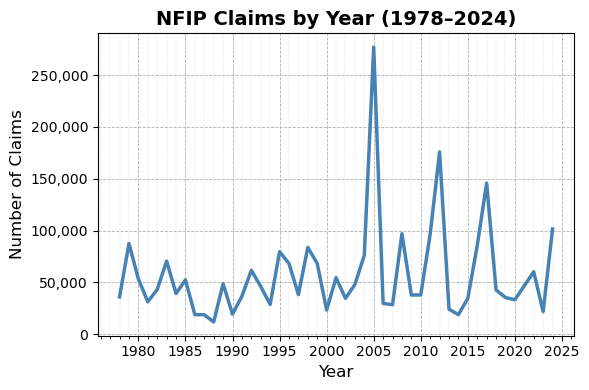

In [23]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.lineplot(
    data=year_loss_df,
    x='yearOfLoss',
    y='countClaims',
    ax=ax,
    linewidth=2.5,
    color='steelblue'
)

ax.set_title("NFIP Claims by Year (1978–2024)", fontsize=14, weight='bold')
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Number of Claims", fontsize=12)

ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

ax.grid(True, which='major', linestyle='--', linewidth=0.6)
ax.grid(True, which='minor', linestyle=':', linewidth=0.3)

plt.tight_layout()
plt.savefig('figures/year-count.png', dpi=200, bbox_inches='tight')

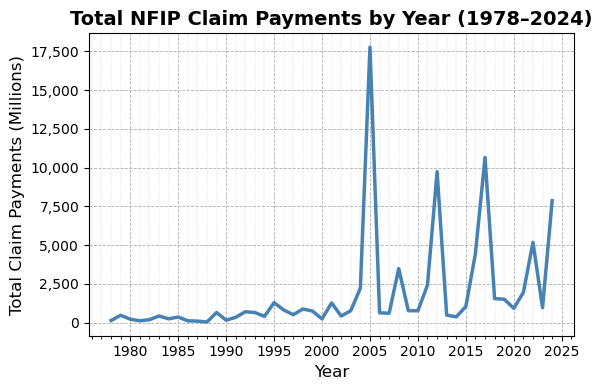

In [24]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.lineplot(
    data=year_loss_df,
    x='yearOfLoss',
    y='paidTotalClaimM',
    ax=ax,
    linewidth=2.5,
    color='steelblue'
)

ax.set_title("Total NFIP Claim Payments by Year (1978–2024)", fontsize=14, weight='bold')
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Total Claim Payments (Millions)", fontsize=12)

ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

ax.grid(True, which='major', linestyle='--', linewidth=0.6)
ax.grid(True, which='minor', linestyle=':', linewidth=0.3)

plt.tight_layout()

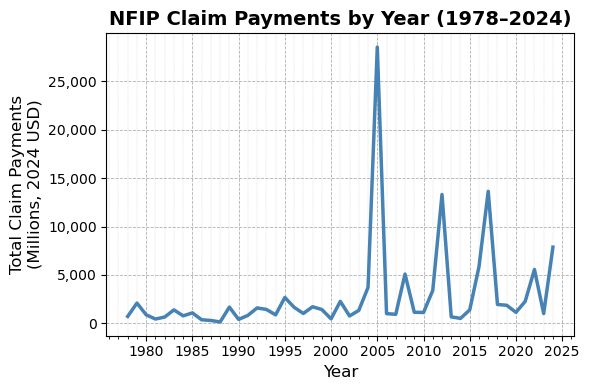

In [25]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.lineplot(
    data=year_loss_df,
    x='yearOfLoss',
    y='paidTotalClaim2024M',
    ax=ax,
    linewidth=2.5,
    color='steelblue'
)

ax.set_title(
    "NFIP Claim Payments by Year (1978–2024)",
    fontsize=14,
    weight='bold'
)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Total Claim Payments\n(Millions, 2024 USD)", fontsize=12)

ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

ax.grid(True, which='major', linestyle='--', linewidth=0.6)
ax.grid(True, which='minor', linestyle=':', linewidth=0.3)

plt.tight_layout()
plt.savefig('figures/year-amount-paid.png', dpi=300, bbox_inches='tight')

# Top 10 Most Significant Flood Events By Total Amount Paid

In [26]:
event_df = con.sql("""
    SELECT
        yearOfLoss,
        floodEvent,
        COUNT(id) AS countClaims,
        ROUND(
            SUM(amountPaidOnBuildingClaim)
            + SUM(amountPaidOnContentsClaim)
            + SUM(amountPaidOnIncreasedCostOfComplianceClaim), 0)::BIGINT AS paidTotalClaim
    FROM
        claims 
    WHERE
        floodEvent NOT NULL
    GROUP BY
        yearOfLoss,
        floodEvent    
""").df()

print(event_df.shape)
event_df.head()

(240, 4)


,yearOfLoss,floodEvent,countClaims,paidTotalClaim
0,2011,Hurricane Irene,52493,1347399996
1,2020,Hurricane Sally,8120,283572815
2,2008,Hurricane Ike,58126,2702511916
3,2013,Mid-spring storms,3921,90448398
4,1980,Flooding,27561,140880936


In [27]:
event_df['yearOfLossFormatted'] = pd.to_datetime(event_df['yearOfLoss'].astype(str) + "-01-01")

# adjust in 2025 dollars
timestamp = pd.Timestamp(date(2025, 1, 1))

event_df["paidTotalClaim2025"] = event_df.apply(
    lambda x: cpi.inflate(
        x.paidTotalClaim,
        x.yearOfLossFormatted,
        to=timestamp),
    axis=1
)

event_df.head(10)

,yearOfLoss,floodEvent,countClaims,paidTotalClaim,yearOfLossFormatted,paidTotalClaim2025
0,2011,Hurricane Irene,52493,1347399996,2011-01-01,1.943620e+09
1,2020,Hurricane Sally,8120,283572815,2020-01-01,3.491976e+08
2,2008,Hurricane Ike,58126,2702511916,2008-01-01,4.067224e+09
3,2013,Mid-spring storms,3921,90448398,2013-01-01,1.247735e+08
4,1980,Flooding,27561,140880936,1980-01-01,5.752415e+08
5,2019,Tropical Storm Imelda,10940,752448943,2019-01-01,9.496218e+08
6,1994,Flooding,12315,269175458,1994-01-01,5.848785e+08
7,1979,Flooding,14857,89511748,1979-01-01,4.163292e+08
8,2016,Hurricane Hermine,2460,88563321,2016-01-01,1.187509e+08
9,1981,Flooding,16618,89271523,1981-01-01,3.259652e+08


In [28]:
# transform raw dollars to millions and calculate average paid claim
event_df = (
    event_df
    .assign(
        paidTotalClaimM = event_df['paidTotalClaim'] / 1_000_000,
        paidTotalClaimM2025 = event_df['paidTotalClaim2025'] / 1_000_000,
        averagePaidClaim2025 = event_df['paidTotalClaim2025'] / event_df['countClaims']
    )
    .astype({'paidTotalClaimM':int, 'paidTotalClaimM2025':int, 'averagePaidClaim2025':int})
    
    # sort by top 10 events on paid claims in 2025 dollars    
    .sort_values(by='paidTotalClaim2025', ascending=False)
    .head(10)
    .reset_index(drop=True) 
)

# add rank of events
event_df['rank'] = range(1, 11)

# rearrange columns
cols = [
    'rank', 'yearOfLoss', 'floodEvent',
    'countClaims', 'paidTotalClaimM',
    'paidTotalClaimM2025', 'averagePaidClaim2025'
]
 
event_df = event_df.loc[:, cols]

# preview
event_df

,rank,yearOfLoss,floodEvent,countClaims,paidTotalClaimM,paidTotalClaimM2025,averagePaidClaim2025
0,1,2005,Hurricane Katrina,208348,16261,27088,130017
1,2,2012,Hurricane Sandy,144848,8957,12553,86669
2,3,2017,Hurricane Harvey,92398,9055,11846,128209
3,4,2024,Hurricane Helene,57843,6027,6208,107334
4,5,2022,Hurricane Ian,48754,4838,5467,112139
5,6,2008,Hurricane Ike,58126,2702,4067,69972
6,7,2016,Mid-summer severe storms,30018,2533,3397,113169
7,8,2004,Hurricane Ivan,20137,1325,2273,112900
8,9,2001,Tropical Storm Allison,35561,1104,2004,56373
9,10,2011,Hurricane Irene,52493,1347,1943,37026


In [29]:
# convert to Markdown for README display
print(event_df.to_markdown(index=False))

|   rank |   yearOfLoss | floodEvent               |   countClaims |   paidTotalClaimM |   paidTotalClaimM2025 |   averagePaidClaim2025 |
|-------:|-------------:|:-------------------------|--------------:|------------------:|----------------------:|-----------------------:|
|      1 |         2005 | Hurricane Katrina        |        208348 |             16261 |                 27088 |                 130017 |
|      2 |         2012 | Hurricane Sandy          |        144848 |              8957 |                 12553 |                  86669 |
|      3 |         2017 | Hurricane Harvey         |         92398 |              9055 |                 11846 |                 128209 |
|      4 |         2024 | Hurricane Helene         |         57843 |              6027 |                  6208 |                 107334 |
|      5 |         2022 | Hurricane Ian            |         48754 |              4838 |                  5467 |                 112139 |
|      6 |         2008 | Hurrican

# Maps

In [30]:
# count claims by state
state_loss_df = con.sql("""
    SELECT
        state,
        COUNT(id) AS countClaim
    FROM
        claims  
    GROUP BY
        state
    ORDER BY
        state ASC  
""").df()

print(state_loss_df.shape)
state_loss_df.head()

(57, 2)


,state,countClaim
0,AK,778
1,AL,44835
2,AR,10189
3,AS,29
4,AZ,5264


In [31]:
# read states shapefile
path = 'https://www2.census.gov/geo/tiger/TIGER2023/STATE/tl_2023_us_state.zip'
states_gdf = gpd.read_file(path)

# sanity check
print(states_gdf.shape)
states_gdf.head()

(56, 16)


,REGION,DIVISION,STATEFP,STATENS,GEOID,GEOIDFQ,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,3,5,54,01779805,54,0400000US54,WV,West Virginia,00,G4000,A,62266499712,489003081,+38.6472854,-080.6183274,"POLYGON ((-77.75438 39.33346, -77.75422 39.333..."
1,3,5,12,00294478,12,0400000US12,FL,Florida,00,G4000,A,138963763779,45970528648,+28.3989775,-082.5143005,"MULTIPOLYGON (((-83.10874 24.62949, -83.10711 ..."
2,2,3,17,01779784,17,0400000US17,IL,Illinois,00,G4000,A,143778366814,6216688589,+40.1028754,-089.1526108,"POLYGON ((-87.89243 38.28285, -87.89334 38.282..."
3,2,4,27,00662849,27,0400000US27,MN,Minnesota,00,G4000,A,206244555303,18937471947,+46.3159573,-094.1996043,"POLYGON ((-95.31991 48.99892, -95.31778 48.998..."
4,3,5,24,01714934,24,0400000US24,MD,Maryland,00,G4000,A,25151736098,6979330958,+38.9466584,-076.6744939,"POLYGON ((-75.75600 39.24607, -75.75579 39.243..."


In [32]:
# identify CRS
states_gdf.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [33]:
# merge nfip claims to state boundaries
states_merged = states_gdf.merge(
    state_loss_df,
    left_on='STUSPS',
    right_on='state',
    how='left'
)

# sanity check
states_merged.head()

,REGION,DIVISION,STATEFP,STATENS,GEOID,GEOIDFQ,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,state,countClaim
0,3,5,54,01779805,54,0400000US54,WV,West Virginia,00,G4000,A,62266499712,489003081,+38.6472854,-080.6183274,"POLYGON ((-77.75438 39.33346, -77.75422 39.333...",WV,27731
1,3,5,12,00294478,12,0400000US12,FL,Florida,00,G4000,A,138963763779,45970528648,+28.3989775,-082.5143005,"MULTIPOLYGON (((-83.10874 24.62949, -83.10711 ...",FL,447278
2,2,3,17,01779784,17,0400000US17,IL,Illinois,00,G4000,A,143778366814,6216688589,+40.1028754,-089.1526108,"POLYGON ((-87.89243 38.28285, -87.89334 38.282...",IL,52538
3,2,4,27,00662849,27,0400000US27,MN,Minnesota,00,G4000,A,206244555303,18937471947,+46.3159573,-094.1996043,"POLYGON ((-95.31991 48.99892, -95.31778 48.998...",MN,12454
4,3,5,24,01714934,24,0400000US24,MD,Maryland,00,G4000,A,25151736098,6979330958,+38.9466584,-076.6744939,"POLYGON ((-75.75600 39.24607, -75.75579 39.243...",MD,25218


In [34]:
# examine NULLS count
states_merged.loc[states_merged['state'].isnull()]

,REGION,DIVISION,STATEFP,STATENS,GEOID,GEOIDFQ,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,state,countClaim


In [35]:
# calculate clount claims per kilometer and convert land area (sq meters) to sq kilometers
states_merged['claims_per_1000km2'] = states_merged['countClaim'] / (states_merged['ALAND'] / 1_000_000) * 1000

states_merged.head()

,REGION,DIVISION,STATEFP,STATENS,GEOID,GEOIDFQ,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,state,countClaim,claims_per_1000km2
0,3,5,54,01779805,54,0400000US54,WV,West Virginia,00,G4000,A,62266499712,489003081,+38.6472854,-080.6183274,"POLYGON ((-77.75438 39.33346, -77.75422 39.333...",WV,27731,445.359867
1,3,5,12,00294478,12,0400000US12,FL,Florida,00,G4000,A,138963763779,45970528648,+28.3989775,-082.5143005,"MULTIPOLYGON (((-83.10874 24.62949, -83.10711 ...",FL,447278,3218.666419
2,2,3,17,01779784,17,0400000US17,IL,Illinois,00,G4000,A,143778366814,6216688589,+40.1028754,-089.1526108,"POLYGON ((-87.89243 38.28285, -87.89334 38.282...",IL,52538,365.409631
3,2,4,27,00662849,27,0400000US27,MN,Minnesota,00,G4000,A,206244555303,18937471947,+46.3159573,-094.1996043,"POLYGON ((-95.31991 48.99892, -95.31778 48.998...",MN,12454,60.384624
4,3,5,24,01714934,24,0400000US24,MD,Maryland,00,G4000,A,25151736098,6979330958,+38.9466584,-076.6744939,"POLYGON ((-75.75600 39.24607, -75.75579 39.243...",MD,25218,1002.634566


In [36]:
# locate conus only gdf
conus_gdf = states_merged.loc[
    (states_merged['GEOID'].astype(int) <= 56)
    & (~states_merged['GEOID'].isin(['02', '15']))
]

# transform CRS for display
conus_gdf = conus_gdf.to_crs(5070)

conus_gdf.head()

,REGION,DIVISION,STATEFP,STATENS,GEOID,GEOIDFQ,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,state,countClaim,claims_per_1000km2
0,3,5,54,01779805,54,0400000US54,WV,West Virginia,00,G4000,A,62266499712,489003081,+38.6472854,-080.6183274,"POLYGON ((1548777.304 1961418.875, 1548791.323...",WV,27731,445.359867
1,3,5,12,00294478,12,0400000US12,FL,Florida,00,G4000,A,138963763779,45970528648,+28.3989775,-082.5143005,"MULTIPOLYGON (((1318717.052 267177.248, 131868...",FL,447278,3218.666419
2,2,3,17,01779784,17,0400000US17,IL,Illinois,00,G4000,A,143778366814,6216688589,+40.1028754,-089.1526108,"POLYGON ((701650.471 1724476.457, 701575.841 1...",IL,52538,365.409631
3,2,4,27,00662849,27,0400000US27,MN,Minnesota,00,G4000,A,206244555303,18937471947,+46.3159573,-094.1996043,"POLYGON ((50386.396 2888284.096, 50544.128 288...",MN,12454,60.384624
4,3,5,24,01714934,24,0400000US24,MD,Maryland,00,G4000,A,25151736098,6979330958,+38.9466584,-076.6744939,"POLYGON ((1718035.440 1986172.419, 1718118.217...",MD,25218,1002.634566


In [37]:
# identify bounds of map for value scale
conus_gdf['countClaim'].describe()

count        49.000000
mean      54288.489796
std      108108.033186
min         488.000000
25%        5733.000000
50%       14710.000000
75%       49506.000000
max      484666.000000
Name: countClaim, dtype: float64

In [38]:
# function to plot non-conus states
def plot_states(geoid, crs, ax, title):
    
    (states_merged
    .loc[states_merged['GEOID'].isin([geoid])]
    .to_crs(crs)
    .plot(
        column='countClaim',
        legend=True,
        cmap=cmap,
        cax=cax,
        norm=norm,
        ax=ax,
        edgecolor='black'
    )
    .set_title(title, fontsize=7)
)

/var/folders/2_/t32jmn4n7cs9v7ll96cqlmn00000gn/T/ipykernel_28320/358381161.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


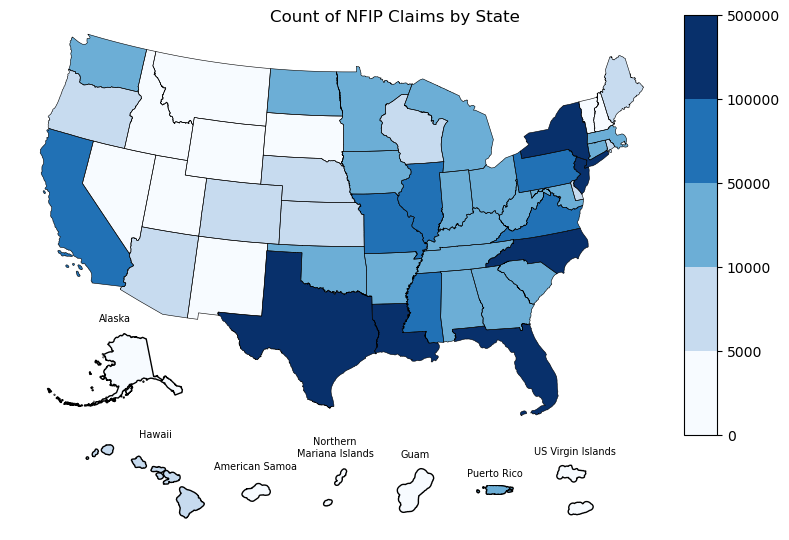

In [39]:
fig, ax = plt.subplots(figsize=(8, 8))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cmap = plt.cm.Blues
norm = mpl.colors.BoundaryNorm(
    [0, 5_000, 10_000, 50_000, 100_000, 500_000],
    cmap.N
)

# plot conus values
conus_gdf.plot(
    column='countClaim',
    legend=True,
    cmap=cmap,
    cax=cax,
    norm=norm,
    ax=ax,
)

# plot conus shapes
conus_gdf.plot(
    ax=ax,
    zorder=1,
    facecolor='None',
    linewidth=.4,
)

# add axes for non-conus states
alaska = fig.add_axes([.05, 0.25, 0.2, 0.1])
hawaii = fig.add_axes([.0, 0.1, 0.4, 0.15])
ams = fig.add_axes([.30, 0.1, 0.05, 0.1])
mp = fig.add_axes([.40, 0.1, 0.05, 0.1])
gu = fig.add_axes([.50, 0.1, 0.05, 0.1])
pr = fig.add_axes([.60, 0.1, 0.05, 0.1])
vi = fig.add_axes([.70, 0.1, 0.05, 0.1])

# plot non-conus states    
plot_states('02', 3338, alaska, 'Alaska')   
plot_states('15', 3760, hawaii, 'Hawaii')  
plot_states('60', 3102, ams, 'American Samoa')  
plot_states('69', 3993, mp, 'Northern\nMariana Islands')
plot_states('66', 3993, gu, 'Guam') 
plot_states('72', 4326, pr, 'Puerto Rico')  
plot_states('78', 3991, vi, 'US Virgin Islands') 
  
# axis aesthetics
ax.axis('off')
ams.axis('off')
ams.set_xlim(left=150_000, right=350_000)
ams.set_ylim(bottom=250_000, top=375_000)
gu.axis('off')
mp.axis('off')
mp.set_ylim(bottom=None, top=275_000)
pr.axis('off')
vi.axis('off')
hawaii.axis('off')
hawaii.set_xlim(700_000)
hawaii.set_ylim(bottom=None, top=1_000_000)
hawaii.set_title('Hawaii', y=.7, fontsize=7)
alaska.axis('off')

fig.suptitle('Count of NFIP Claims by State', y=.75)
fig.tight_layout()
fig.savefig('figures/count-claims-map.png', dpi=200, bbox_inches='tight')

In [40]:
# identify bounds of map
conus_gdf['claims_per_1000km2'].describe()

count       49.000000
mean       800.686786
std       1721.319081
min          2.215080
25%         60.384624
50%        164.112938
75%        635.784549
max      10565.544769
Name: claims_per_1000km2, dtype: float64

/var/folders/2_/t32jmn4n7cs9v7ll96cqlmn00000gn/T/ipykernel_28320/2424924499.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


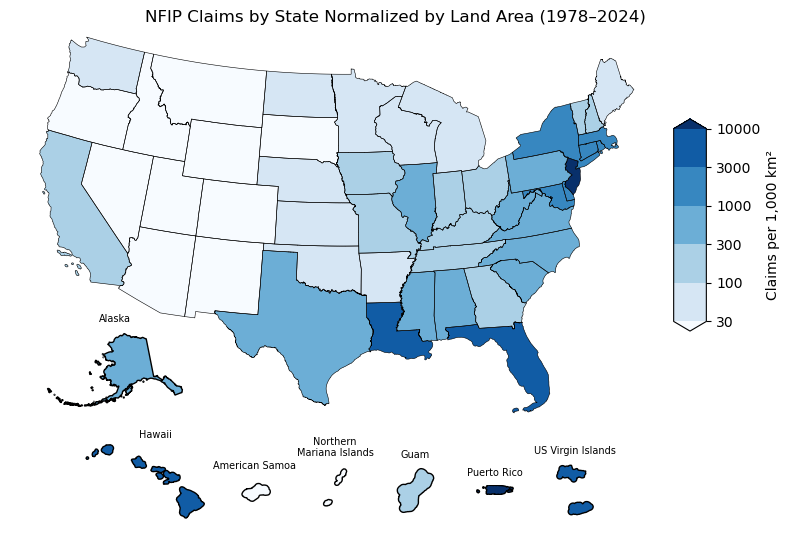

In [41]:
fig, ax = plt.subplots(figsize=(8, 8))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cmap = plt.cm.Blues
boundaries = [30, 100, 300, 1000, 3000, 10000]
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N, extend='both')

# plot conus values
conus_gdf.plot(
    column='claims_per_1000km2',
    legend=True,
    cmap=cmap,
    cax=cax,
    norm=norm,
    ax=ax,
)

# plot conus shapes
conus_gdf.plot(
    ax=ax,
    zorder=1,
    facecolor='None',
    linewidth=.4,
)

# add axes for non-conus states
alaska = fig.add_axes([.05, 0.25, 0.2, 0.1])
hawaii = fig.add_axes([.0, 0.1, 0.4, 0.15])
ams = fig.add_axes([.30, 0.1, 0.05, 0.1])
mp = fig.add_axes([.40, 0.1, 0.05, 0.1])
gu = fig.add_axes([.50, 0.1, 0.05, 0.1])
pr = fig.add_axes([.60, 0.1, 0.05, 0.1])
vi = fig.add_axes([.70, 0.1, 0.05, 0.1])
    
# plot non-conus states    
plot_states('02', 3338, alaska, 'Alaska')   
plot_states('15', 3760, hawaii, 'Hawaii')  
plot_states('60', 3102, ams, 'American Samoa')  
plot_states('69', 3993, mp, 'Northern\nMariana Islands')
plot_states('66', 3993, gu, 'Guam') 
plot_states('72', 4326, pr, 'Puerto Rico')  
plot_states('78', 3991, vi, 'US Virgin Islands') 
  
# axis aesthetics
ax.axis('off')
ams.axis('off')
ams.set_xlim(left=150_000, right=350_000)
ams.set_ylim(bottom=250_000, top=375_000)
gu.axis('off')
mp.axis('off')
mp.set_ylim(bottom=None, top=275_000)
pr.axis('off')
vi.axis('off')
hawaii.axis('off')
hawaii.set_xlim(700_000)
hawaii.set_ylim(bottom=None, top=1_000_000)
hawaii.set_title('Hawaii', y=.7, fontsize=7)
alaska.axis('off')

cax.set_ylabel('Claims per 1,000 km²', fontsize=10)

fig.suptitle(
    'NFIP Claims by State Normalized by Land Area (1978–2024)',
    fontsize=12,
    y=0.75
)

fig.tight_layout()
fig.savefig('figures/count-claims-norm-map.png', dpi=200, bbox_inches='tight')